# Hybrid book recommender system

The objetive of this project is to create a hybrid book recommendation system that combines three types of recommenders:
- Simple recommender
- Collaborative filtering engine
- Content-based recommenders

The dataset user is available at https://www.kaggle.com/arashnic/book-recommendation-dataset/version/1

More information on the three types of recommenders available at https://www.datacamp.com/community/tutorials/recommender-systems-python (partial tutorial, using a different dataset).

## Imports

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Preprocess Books.csv

## Load data

In [3]:
books_raw = pd.read_csv ('dataset1/Books.csv',
                         dtype={
                             'ISBN' : str, # some values are not integers
                             'Book-Title' : str,
                             'Book-Author' : str,
                             'Year-Of-Publication' : str, # some values are not integers
                             'Publisher' : str,
                             'Image-URL-S' : str},
     usecols=['ISBN','Book-Title','Book-Author','Year-Of-Publication','Publisher','Image-URL-S'])

## Explore 'books_raw'

Books are identified by their respective ISBN. Invalid ISBNs have already been removed from the dataset. Moreover, some content-based information is given (Book-Title, Book-Author, Year-Of-Publication, Publisher), obtained from Amazon Web Services. Note that in case of several authors, only the first is provided. URLs linking to cover images are also given, appearing in three different flavours (Image-URL-S, Image-URL-M, Image-URL-L), i.e., small, medium, large. These URLs point to the Amazon web site.

In [4]:
books_raw.shape

(271360, 6)

In [5]:
books_raw.count()

ISBN                   271360
Book-Title             271360
Book-Author            271359
Year-Of-Publication    271360
Publisher              271358
Image-URL-S            271360
dtype: int64

There are missing values at least in Book-Author and Publisher

In [6]:
books_raw.isna().sum()

ISBN                   0
Book-Title             0
Book-Author            1
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
dtype: int64

## Analyse ISBN

### Are all ISBN numbers?

In [39]:
pd.to_numeric(books_raw['ISBN'], errors='coerce').isna().sum()

22333

Some ISBM have the letter X at the end, so we'll leave them as strings

### Any ISBN duplicates?

In [23]:
books_raw.ISBN.value_counts().max()

1

No repeated ISBN

## Analyse Book-Title

### Any missing values?

In [30]:
pd.isnull(books_raw["Book-Title"]).sum()

0

Great! No missing Book-Title

### Any Book-Title duplicates?

In [31]:
books_raw[books_raw.duplicated(['Book-Title'])]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S
239,0743486226,Angels &amp; Demons,Dan Brown,2003,Atria,http://images.amazon.com/images/P/0743486226.0...
355,0140374248,James and the Giant Peach,Roald Dahl,2000,Penguin USA (Paper),http://images.amazon.com/images/P/0140374248.0...
405,006101351X,The Perfect Storm : A True Story of Men Agains...,Sebastian Junger,1998,HarperTorch,http://images.amazon.com/images/P/006101351X.0...
456,044021145X,The Firm,John Grisham,1992,Bantam Dell Publishing Group,http://images.amazon.com/images/P/044021145X.0...
475,014023828X,The Tortilla Curtain,T. Coraghessan Boyle,1996,Penguin Books,http://images.amazon.com/images/P/014023828X.0...
...,...,...,...,...,...,...
271246,0195124995,For Cause and Comrades: Why Men Fought in the ...,James M. McPherson,1998,Oxford University Press,http://images.amazon.com/images/P/0195124995.0...
271315,1902852036,All the Queen's Men,Nick Elwood,1999,Gay Men's Press,http://images.amazon.com/images/P/1902852036.0...
271316,0441011799,Singularity Sky,Charles Stross,2004,Ace,http://images.amazon.com/images/P/0441011799.0...
271346,0395264707,Dreamsnake,Vonda N. McIntyre,1978,Houghton Mifflin,http://images.amazon.com/images/P/0395264707.0...


In [32]:
# let's look at the duplicates of the first value
books_raw.loc[books_raw['Book-Title'] == 'Angels &amp; Demons']

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S
118,0671027360,Angels &amp; Demons,Dan Brown,2001,Pocket Star,http://images.amazon.com/images/P/0671027360.0...
239,0743486226,Angels &amp; Demons,Dan Brown,2003,Atria,http://images.amazon.com/images/P/0743486226.0...
28002,0671027352,Angels &amp; Demons,Dan Brown,2000,Atria,http://images.amazon.com/images/P/0671027352.0...
36935,0743535774,Angels &amp; Demons,Dan Brown,2003,Audioworks,http://images.amazon.com/images/P/0743535774.0...
163541,0743535766,Angels &amp; Demons,Dan Brown,2003,Simon &amp; Schuster Audio,http://images.amazon.com/images/P/0743535766.0...


These are different editions of the same title, so they are not duplicates.

### Any empty title names?

In [33]:
books_raw.loc[books_raw['Book-Title'].isnull(),'Book-Title'].count()

0

No. We're all good!

### Any empty or zero years?

In [34]:
books_raw.loc[books_raw['Year-Of-Publication'].isnull(),'Year-Of-Publication'].count()

0

No empty Year-Of-Publication

In [35]:
books_raw.loc[books_raw['Year-Of-Publication']=='0','Year-Of-Publication'].count()

4618

There are at least 4618 books without a valid Year-Of-Publication.

# Preprocess Ratings.csv

## Load data

In [36]:
ratings_raw = pd.read_csv ('dataset1/Ratings.csv', dtype={
    'User-ID':str, # some values are not integers
    'ISBN':str, # some values are not integers
    'Book-Rating':int
})

## Explore Ratings_raw dataframe

Contains the book rating information. Ratings (Book-Rating) are either explicit, expressed on a scale from 1-10 (higher values denoting higher appreciation), or implicit, expressed by 0.

In [37]:
list(ratings_raw.columns)

['User-ID', 'ISBN', 'Book-Rating']

In [38]:
ratings_raw.shape

(1149780, 3)

In [18]:
ratings_raw.count()

User-ID        1149780
ISBN           1149780
Book-Rating    1149780
dtype: int64

In [19]:
ratings_raw.dtypes

User-ID        object
ISBN           object
Book-Rating     int64
dtype: object

## Analyse User-ID

### Any missing values?

In [22]:
ratings_raw.loc[ratings_raw['User-ID'].isnull(),'User-ID'].count()

0

### Are all User-ID numbers?

In [26]:
ID_error = pd.to_numeric(ratings_raw['User-ID'], errors='coerce').isna()
ratings_raw.loc[ID_error]

,User-ID,ISBN,Book-Rating


All are numbers, so we will convert them to integers.

In [28]:
ratings_raw["User-ID"] = pd.to_numeric(ratings_raw["User-ID"])

In [29]:
ratings_raw['User-ID'].dtypes

dtype('int64')

### How many unique User-ID?

In [30]:
pd.unique(pd.Series(ratings_raw['User-ID'])).shape[0]

105283

### Any Unique-ID with value zero?

In [31]:
# User-ID are stored as strings
(ratings_raw['User-ID'] == "0").sum()

0

No ID zero present

## Analyse Book-Rating

In [32]:
sorted(set(ratings_raw['Book-Rating'].tolist()))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

The zeros are inferred values. Let's see how many are there.

In [33]:
ratings_raw['Book-Rating'].tolist().count(0)

716109

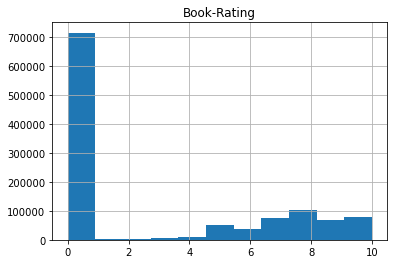

In [34]:
hist = ratings_raw.hist(bins=11,column='Book-Rating')

# Preprocess Users.csv

## Load data

In [42]:
users_raw = pd.read_csv ('dataset1/Users.csv', dtype={
    'User-ID':int,
    'Location':str,
    'Age':str # some values are not integers
})

## Explore dataframe

Contains the users. Note that user IDs (User-ID) have been anonymized and map to integers. Demographic data is provided (Location, Age) if available. Otherwise, these fields contain NULL-values.

In [43]:
list(users_raw.columns)

['User-ID', 'Location', 'Age']

In [44]:
users_raw.shape

(278858, 3)

In [45]:
users_raw.count()

User-ID     278858
Location    278858
Age         168096
dtype: int64

In [46]:
users_raw.dtypes

User-ID      int64
Location    object
Age         object
dtype: object

## Analyse User-ID

### Any missing values?

In [47]:
users_raw.loc[ratings_raw['User-ID'].isnull(),'User-ID'].count()

0

Great! No missing IDs.

## Analyse Location

In [48]:
users_raw['Location']

0                         nyc, new york, usa
1                  stockton, california, usa
2            moscow, yukon territory, russia
3                  porto, v.n.gaia, portugal
4         farnborough, hants, united kingdom
                         ...                
278853                 portland, oregon, usa
278854    tacoma, washington, united kingdom
278855             brampton, ontario, canada
278856             knoxville, tennessee, usa
278857                  dublin, n/a, ireland
Name: Location, Length: 278858, dtype: object

In [49]:
users_raw.loc[users_raw['Location'].isnull(),'Location'].count()

0

Great! No missing locations.

## Age 

### Missing values

In [51]:
users_raw['Age'].isnull().sum()

110762

Thera re many users missing age information.

In [52]:
users_raw['Age'] = pd.to_numeric(users_raw['Age'], errors='coerce')

Let's replace missing age with the average reader age

In [53]:
age_mean = users_raw['Age'].mean()
age_mean

34.75143370454978

In [54]:
users_raw['Age'].fillna(age_mean)

0         34.751434
1         18.000000
2         34.751434
3         17.000000
4         34.751434
            ...    
278853    34.751434
278854    50.000000
278855    34.751434
278856    34.751434
278857    34.751434
Name: Age, Length: 278858, dtype: float64

## Remove hyphens from column names

In [55]:
books_raw.columns

Index(['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher',
       'Image-URL-S'],
      dtype='object')

In [56]:
books_raw.rename(columns={'Book-Title':'Book_Title',
                      'Book-Author':'Book_Author',
                      'Year-Of-Publication':'Year_Of_Publication',
                      'Image-URL-S':'Image_URL_S'}, inplace=True)

In [57]:
ratings_raw.columns

Index(['User-ID', 'ISBN', 'Book-Rating'], dtype='object')

In [58]:
ratings_raw.rename(columns={'User-ID':'User_ID',
                        'Book-Rating':'Book_Rating'}, inplace=True)

In [59]:
users_raw.columns

Index(['User-ID', 'Location', 'Age'], dtype='object')

In [60]:
users_raw.rename(columns={'User-ID':'User_ID'}, inplace=True)

# Export preprocessed dataframes

In [61]:
books_raw.to_pickle("./pickle_files/d1_books.pkl")
ratings_raw.to_pickle("./pickle_files/d1_ratings.pkl")
users_raw.to_pickle("./pickle_files/d1_users.pkl")

### End of preprocessing